<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Download-and-Clean-Data" data-toc-modified-id="Download-and-Clean-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Download and Clean Data</a></span></li><li><span><a href="#Making-Recommendations" data-toc-modified-id="Making-Recommendations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Making Recommendations</a></span><ul class="toc-item"><li><span><a href="#BERT" data-toc-modified-id="BERT-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>BERT</a></span></li><li><span><a href="#Doc2vec" data-toc-modified-id="Doc2vec-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Doc2vec</a></span></li><li><span><a href="#LDA" data-toc-modified-id="LDA-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LDA</a></span></li><li><span><a href="#TFIDF" data-toc-modified-id="TFIDF-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>TFIDF</a></span></li><li><span><a href="#WikilinkNN" data-toc-modified-id="WikilinkNN-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>WikilinkNN</a></span></li><li><span><a href="#Weighted-Model" data-toc-modified-id="Weighted-Model-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Weighted Model</a></span></li></ul></li></ul></div>

**rec_books**

Downloads an English Wikipedia dump and parses it for all available books. All available models are then ran to compare recommendation efficacy.

If using this notebook in [Google Colab](https://colab.research.google.com/github/andrewtavis/wikirec/blob/main/examples/rec_books.ipynb), you can activate GPUs by following `Edit > Notebook settings > Hardware accelerator` and selecting `GPU`.

In [1]:
# pip install wikirec -U

The following gensim update might be necessary in Google Colab as the default version is very low.

In [2]:
# pip install gensim -U

In Colab you'll also need to download nltk's names data.

In [3]:
# import nltk
# nltk.download("names")

In [1]:
import os
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.set(rc={"figure.figsize": (15, 5)})

from wikirec import data_utils, model, utils

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:99% !important; }</style>"))

# Download and Clean Data

In [ ]:
files = data_utils.download_wiki(
    language="en", target_dir="./enwiki_dump", file_limit=-1, dump_id=False
)
len(files)

DL file to ./enwiki_dump/enwiki-20210401-pages-articles-multistream2.xml-p41243p151573.bz2
  4751360/334526368 [..............................] - ETA: 1:18

In [2]:
topic = "books"

In [3]:
data_utils.parse_to_ndjson(
    topics=topic,
    output_path="./enwiki_books.ndjson",
    input_dir="./enwiki_dump",
    partitions_dir="./enwiki_book_partitions",
    limit=None,
    delete_parsed_files=True,
    multicore=True,
    verbose=True,
)

File ./enwiki_books.ndjson with articles for the given topics already exists


In [4]:
with open("./enwiki_books.ndjson", "r") as fin:
    books = [json.loads(l) for l in fin]

print(f"Found a total of {len(books)} books.")

Found a total of 41234 books.


In [6]:
titles = [m[0] for m in books]
texts = [m[1] for m in books]

In [8]:
if os.path.isfile("./book_corpus_idxs.pkl"):
    print(f"Loading book corpus and selected indexes")
    with open(f"./book_corpus_idxs.pkl", "rb") as f:
        text_corpus, selected_idxs = pickle.load(f)
        selected_titles = [titles[i] for i in selected_idxs]

else:
    print(f"Creating book corpus and selected indexes")
    text_corpus, selected_idxs = data_utils.clean(
        texts=texts,
        language="en",
        min_token_freq=5,  # 0 for Bert
        min_token_len=3,  # 0 for Bert
        min_tokens=50,
        max_token_index=-1,
        min_ngram_count=3,
        remove_stopwords=True,  # False for Bert
        ignore_words=None,
        remove_names=True,
        sample_size=1,
        verbose=True,
    )

    selected_titles = [titles[i] for i in selected_idxs]

    with open("./book_corpus_idxs.pkl", "wb") as f:
        print("Pickling book corpus and selected indexes")
        pickle.dump([text_corpus, selected_idxs], f, protocol=4)

Loading book corpus and selected indexes


# Making Recommendations

In [9]:
single_input_0 = "Harry Potter and the Philosopher's Stone"
single_input_1 = "The Hobbit"
multiple_inputs = ["Harry Potter and the Philosopher's Stone", "The Hobbit"]

In [10]:
def load_or_create_sim_matrix(
    method,
    corpus,
    metric,
    topic,
    path="./",
    bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
    **kwargs,
):
    """
    Loads or creats a similarity matrix to deliver recommendations
    
    NOTE: the .pkl files made are 5-10GB or more in size
    """
    if os.path.isfile(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl"):
        print(f"Loading {method} {topic} {metric} similarity matrix")
        with open(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl", "rb") as f:
            sim_matrix = pickle.load(f)

    else:
        print(f"Creating {method} {topic} {metric} similarity matrix")
        embeddings = model.gen_embeddings(
            method=method, corpus=corpus, bert_st_model=bert_st_model, **kwargs,
        )
        sim_matrix = model.gen_sim_matrix(
            method=method, metric=metric, embeddings=embeddings,
        )

        with open(f"{path}{topic}_{metric}_{method}_sim_matrix.pkl", "wb") as f:
            print(f"Pickling {method} {topic} {metric} similarity matrix")
            pickle.dump(sim_matrix, f, protocol=4)

    return sim_matrix

## BERT

In [11]:
# Remove n-grams for BERT training
corpus_no_ngrams = [
    " ".join([t for t in text.split(" ") if "_" not in t]) for text in text_corpus
]

In [12]:
# We can pass kwargs for sentence_transformers.SentenceTransformer.encode
bert_sim_matrix = load_or_create_sim_matrix(
    method="bert",
    corpus=corpus_no_ngrams,
    metric="cosine",  # euclidean
    topic=topic,
    path="./",
    bert_st_model="xlm-r-bert-base-nli-stsb-mean-tokens",
    show_progress_bar=True,
    batch_size=32,
)

Loading bert books cosine similarity matrix


In [17]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=bert_sim_matrix,
    n=10,
    metric="cosine",
)

[['Harry Potter and the Goblet of Fire', 0.9275407],
 ['Harry Potter and the Deathly Hallows', 0.92178226],
 ['A Monster Calls', 0.9148517],
 ['Spells', 0.9139519],
 ['Matilda', 0.9071869],
 ['Wildwood', 0.9070556],
 ['The Hobbit', 0.9052026],
 ['Harry Potter and the Order of the Phoenix', 0.9049706],
 ["The Magician's Nephew", 0.9039968],
 ['The Silver Chair', 0.89989555]]

In [18]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=bert_sim_matrix,
    n=10,
    metric="cosine",
)

[['The Seeing Stone', 0.9184302],
 ['Charmed Life', 0.9156177],
 ['Spellbound', 0.9137267],
 ['The Little Grey Men', 0.91196114],
 ['The Ring of Solomon', 0.909929],
 ['The Magic Finger', 0.9097778],
 ['I, Coriander', 0.90645945],
 ["Harry Potter and the Philosopher's Stone", 0.9052026],
 ["All Thirteen: The Incredible Cave Rescue of the Thai Boys' Soccer Team",
  0.9048355],
 ['Miss Hickory', 0.9041687]]

In [19]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=bert_sim_matrix,
    n=10,
    metric="cosine",
)

[['The Little Grey Men', 0.9031571],
 ['The Magic Finger', 0.90149724],
 ['Matilda', 0.9011334],
 ['The Seeing Stone', 0.90090525],
 ['A Monster Calls', 0.9001728],
 ['Spells', 0.89896786],
 ['Charmed Life', 0.89813614],
 ["The Magician's Nephew", 0.896847],
 ['The Lion, the Witch and the Wardrobe', 0.8954387],
 ['I, Coriander', 0.8934685]]

## Doc2vec

In [20]:
# We can pass kwargs for gensim.models.doc2vec.Doc2Vec
doc2vec_sim_matrix = load_or_create_sim_matrix(
    method="doc2vec",
    corpus=text_corpus,
    metric="cosine",  # euclidean
    topic=topic,
    path="./",
    vector_size=100,
    epochs=10,
    alpha=0.025,
)

Loading doc2vec books cosine similarity matrix


In [21]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=doc2vec_sim_matrix,
    n=10,
    metric="cosine",
)

[['Harry Potter and the Deathly Hallows', 0.5511563189854312],
 ['Lost Horizon', 0.5103009837821468],
 ['Anatomy of an Epidemic', 0.4970893231596097],
 ['Weird Tales 4', 0.48898032440744255],
 ['The Wounded Surgeon', 0.4833330319649109],
 ['Imperial Twilight', 0.4792812442960969],
 ['Weird Tales 3', 0.47755804117322587],
 ['The Under Dog and Other Stories', 0.47338214151878044],
 ['The Most Famous Man in America', 0.4633816267660689],
 ['For the Relief of Unbearable Urges', 0.4626855509914502]]

In [22]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=doc2vec_sim_matrix,
    n=10,
    metric="cosine",
)

[['Tao of Jeet Kune Do', 0.586374200273839],
 ['A Light in the Attic', 0.5638286586776491],
 ['Lockdown', 0.5613684142608049],
 ['The Particular Sadness of Lemon Cake', 0.561304264201524],
 ['Boy', 0.5588912646328453],
 ['The Lord of the Rings', 0.55433004434006],
 ['P Is for Pterodactyl', 0.5461079467564652],
 ['The Great American Baseball Card Flipping, Trading and Bubble Gum Book',
  0.5397654380217243],
 ['Lord of the Flies', 0.5381416487324301],
 ['Paddle-to-the-Sea', 0.5344509860228208]]

In [23]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=doc2vec_sim_matrix,
    n=10,
    metric="cosine",
)

[['Harry Potter and the Deathly Hallows', 0.48558120738039856],
 ['A Light in the Attic', 0.48500627971994403],
 ['Tao of Jeet Kune Do', 0.47221065020311254],
 ['A Patchwork Planet', 0.46084408429874313],
 ['P Is for Pterodactyl', 0.4607802513235646],
 ['The Tale of Samuel Whiskers or The Roly-Poly Pudding', 0.44526299997355046],
 ['Buckskin Brigades', 0.4440458628502496],
 ['Hello Lighthouse', 0.44398529880926535],
 ['Harry Potter and the Half-Blood Prince', 0.4282244056218962],
 ['Lord of the Flies', 0.4266990155722771]]

## LDA

LDA models ran:   0%|          | 0/12 [00:00<?, ?it/s]

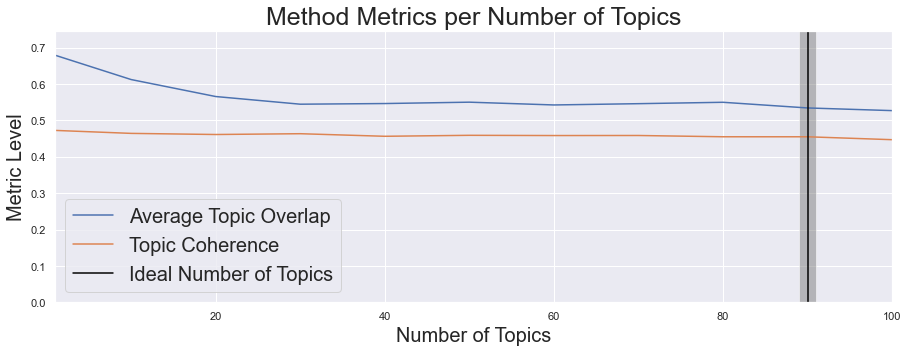

In [16]:
topic_nums_to_compare = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# We can pass kwargs for gensim.models.ldamulticore.LdaMulticore
utils.graph_lda_topic_evals(
    corpus=text_corpus,
    num_topic_words=10,
    topic_nums_to_compare=topic_nums_to_compare,
    metrics=True,
    verbose=True,
)

plt.show()

In [24]:
# We can pass kwargs for gensim.models.ldamulticore.LdaMulticore
lda_sim_matrix = load_or_create_sim_matrix(
    method="lda",
    corpus=text_corpus,
    metric="cosine",  # euclidean not an option at this time
    topic=topic,
    path="./",
    num_topics=90,
    passes=10,
    decay=0.5,
)

Loading lda books cosine similarity matrix


In [17]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=lda_sim_matrix,
    n=10,
    metric="cosine",
)

[['Harry Potter and the Chamber of Secrets', 0.99455196],
 ['Harry Potter and the Half-Blood Prince', 0.978615],
 ['Artemis Fowl', 0.9756279],
 ['Harry Potter and the Goblet of Fire', 0.96870595],
 ['Harry Potter and the Deathly Hallows', 0.9509542],
 ['Harry Potter and the Order of the Phoenix', 0.9505762],
 ['The Troubled Man', 0.94174504],
 ['A Morbid Taste for Bones', 0.9339708],
 ['One Corpse Too Many', 0.9328407],
 ['The Cat in the Hat', 0.9263108]]

In [25]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=lda_sim_matrix,
    n=10,
    metric="cosine",
)

[['The Mystery at Lilac Inn', 0.9999413],
 ['A Secret Vice', 0.9998557],
 ['The Lord of the Rings', 0.99977183],
 ["The Countess of Pembroke's Arcadia", 0.9976354],
 ['Mythology', 0.99716675],
 ['The Monsters and the Critics, and Other Essays', 0.9970264],
 ['How to Talk Minnesotan', 0.99561405],
 ['The History of The Hobbit', 0.99519783],
 ['The Annotated Hobbit', 0.9948809],
 ["The Lord of the Rings: A Reader's Companion", 0.9946786]]

In [26]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=lda_sim_matrix,
    n=10,
    metric="cosine",
)

[['The Two Towers', 0.6737263],
 ['The Tolkien Reader', 0.5701004],
 ["Tolkien's Legendarium", 0.5401918],
 ['The Hurricane Party', 0.53934956],
 ['Journeys of Frodo', 0.5365135],
 ['The Lost Road and Other Writings', 0.53360015],
 ['Moby-Dick', 0.5240759],
 ['Charlie and the Chocolate Factory', 0.5172413],
 ["The Lord of the Rings: A Reader's Companion", 0.5172281],
 ['The Lord of the Rings', 0.51478237]]

## TFIDF

In [13]:
# We can pass kwargs for sklearn.feature_extraction.text.TfidfVectorizer
tfidf_sim_matrix = load_or_create_sim_matrix(
    method="tfidf",
    corpus=text_corpus,
    metric="cosine",  # euclidean
    topic=topic,
    path="./",
    max_features=None,
    norm='l2',
)

Loading tfidf books cosine similarity matrix


In [29]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=tfidf_sim_matrix,
    n=10,
    metric="cosine",
)

[['Harry Potter and the Chamber of Secrets', 0.6644434544958339],
 ['Harry Potter and the Deathly Hallows', 0.6547119201881699],
 ['Harry Potter and the Order of the Phoenix', 0.642515197024424],
 ['Harry Potter and the Half-Blood Prince', 0.6420367483506718],
 ['Harry Potter and the Goblet of Fire', 0.5951892674032896],
 ['The Magical Worlds of Harry Potter', 0.5609077339791474],
 ['Harry Potter and the Methods of Rationality', 0.5379869646546271],
 ['Harry, A History', 0.5360108950074289],
 ['Harry Potter and the Cursed Child', 0.5019619677408425],
 ['Fantastic Beasts and Where to Find Them', 0.48860861798783956]]

In [30]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=tfidf_sim_matrix,
    n=10,
    metric="cosine",
)

[['The History of The Hobbit', 0.6968314428704283],
 ['The Annotated Hobbit', 0.6056439862168547],
 ['The Lord of the Rings', 0.5579023075664765],
 ['The Road to Middle-Earth', 0.5376868352509242],
 ['Mr. Bliss', 0.49951465923170035],
 ['The Letters of J. R. R. Tolkien', 0.49586730946969954],
 ['J. R. R. Tolkien: A Biography', 0.491002699969649],
 ['The Fellowship of the Ring', 0.4725626366254413],
 ['Tolkien: Maker of Middle-earth', 0.46079070209443573],
 ["Bilbo's Last Song", 0.45336292390290156]]

In [31]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=tfidf_sim_matrix,
    n=10,
    metric="cosine",
)

[['The History of The Hobbit', 0.3630409561901944],
 ['Harry Potter and the Chamber of Secrets', 0.35662779096968417],
 ['Harry Potter and the Deathly Hallows', 0.3525511840389999],
 ['Harry Potter and the Half-Blood Prince', 0.34751621204943556],
 ['Harry Potter and the Order of the Phoenix', 0.3429859797299906],
 ['Harry Potter and the Goblet of Fire', 0.32341644906938327],
 ['The Annotated Hobbit', 0.3146736587107837],
 ['The Lord of the Rings', 0.3108195325708887],
 ['The Magical Worlds of Harry Potter', 0.308962426272421],
 ['Harry Potter and the Methods of Rationality', 0.28898077558075325]]

## WikilinkNN

In [ ]:
# We can pass kwargs for the WikilinkNN Keras model
wikilink_sim_matrix = load_or_create_sim_matrix(
    method="wikilinknn",
    corpus=text_corpus,
    metric="cosine",  # euclidean
    topic=topic,
    path="./",
    embedding_size=75,
    epochs=20,
    verbose=True,
)

In [ ]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=wikilink_sim_matrix,
    n=10,
    metric="cosine",
)

In [ ]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=wikilink_sim_matrix,
    n=10,
    metric="cosine",
)

In [ ]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=wikilink_sim_matrix,
    n=10,
    metric="cosine",
)

## Weighted Model

In [ ]:
# wikilink_sims_copy = wikilink_sims.copy()
# not_selected_idxs = [i for i in range(len(titles)) if i not in selected_idxs]

# wikilink_sims_copy = np.delete(wikilink_sims_copy, not_selected_idxs, axis=0)
# wikilink_sims_copy = np.delete(wikilink_sims_copy, not_selected_idxs, axis=1)

In [ ]:
tfidf_weight = 0.35
bert_weight = 1.0 - tfidf_weight
bert_tfidf_sim_matrix = tfidf_weight * tfidf_sim_matrix + bert_weight * bert_sim_matrix

In [ ]:
model.recommend(
    inputs=single_input_0,
    titles=selected_titles,
    sim_matrix=bert_tfidf_sim_matrix,
    n=10,
    metric="cosine",
)

In [ ]:
model.recommend(
    inputs=single_input_1,
    titles=selected_titles,
    sim_matrix=bert_tfidf_sim_matrix,
    n=10,
    metric="cosine",
)

In [ ]:
model.recommend(
    inputs=multiple_inputs,
    titles=selected_titles,
    sim_matrix=bert_tfidf_sim_matrix,
    n=10,
    metric="cosine",
)